In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [148]:
labelled_data = pd.read_csv("train.csv")
dev_data = pd.read_csv("test.csv")

In [149]:
#data preparation
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(labelled_data, 0.25)
train_set = train_set.T
train_set  = np.array(train_set)
X_train = train_set[1:] / 255
Y_train = train_set[0]

test_set = test_set.T
test_set = np.array(test_set)
X_test = test_set[1:] / 255
Y_test = test_set[0]
train_set = np.array(train_set)
test_set = np.array(test_set)

m, n = X_train.shape

dev_data = dev_data.T
dev_data = np.array(dev_data)
np.random.shuffle(dev_data)
X_dev = dev_data[:] / 255

In [150]:
input_size = m
hidden_size = 16
output_size = 10
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        """
        Initialize the neural network with given parameters.

        Args:
            input_size (int): Number of input features.
            hidden_size (int): Number of neurons in the hidden layer.
            output_size (int): Number of output classes.
            learning_rate (float): Learning rate for gradient descent.

        Attrs:
            input_size (int): Number of input features.
            hidden_size (int): Number of neurons in the hidden layer.
            output_size (int): Number of output classes.
            learning_rate (float): Learning rate for gradient descent.
            W1, b1, W2, b2, W3, b3 (numpy.ndarray): Parameters of the neural network ie (Weights and biases)
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        self.W1, self.b1, self.W2, self.b2, self.W3, self.b3 = self.initialize_parameters()
        
    def initialize_parameters(self):
        """
        Initialize the parameters of the neural network.

        Returns:
            List of numpy arrays: Initialized weights and biases.
        """
        # Calculate the scaling factor for weight initialization using He initialization
        factor = np.sqrt(2 / input_size)
        
        W1 = np.random.rand(hidden_size, input_size) * factor
        b1 = np.random.rand(hidden_size, 1) * factor
        W2 = np.random.rand(hidden_size, hidden_size) * factor
        b2 = np.random.rand(hidden_size, 1) * factor
        W3 = np.random.rand(output_size, hidden_size) * factor
        b3 = np.random.rand(output_size, 1) * factor
    
        return W1, b1, W2, b2, W3, b3
    @staticmethod
    def ReLU(Z):
        """
        ReLU activation function.

        Args:
            Z (ndarray): Input to the activation function.

        Returns:
            ndarray: Output of the activation function.
        """
        return np.maximum(Z, 0)
    @staticmethod
    def ReLU_derivative(Z):
        """
        Derivative of ReLU activation function.

        Args:
            Z (ndarray): Input to the activation function.

        Returns:
            ndarray: Derivative of the activation function.
        """
        return Z > 0
        # TODO: Check why the model prediction degrades with these activation functions
    # @staticmethod
    # def sigmoid(Z):
    #     return 1/(1+np.exp(-Z))
    # 
    # def sigmoid_derivative(Z):
    #     return 1/(1+np.exp(-Z))
    # 
    # def tanh(Z):
    #     numerator = np.exp(Z) - np.exp(-Z)
    #     denominator = np.exp(Z) + np.exp(-Z)
    #     return numerator / denominator
    # 
    # def tanh_derivative(Z):
    #     return 1 - np.power(Z, 2)
    @staticmethod
    def softmax(Z):
        return np.exp(Z) / sum(np.exp(Z))
    
    @staticmethod
    def one_hot_encoder(Y):
        """
        Convert integer labels to one-hot encoded vectors.

        Args:
            Y (ndarray): Integer labels.

        Returns:
            ndarray: One-hot encoded sparse-vectors.
        """
         
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def forward_propagation(self, X):
        """
        Performs forward propagation through the network.

        Args:
            X: Input data (input_size, n_samples)

        Returns:
            list containing the activations of each layer (Z1, A1, Z2, A2, Z3, A3)
        """
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = self.ReLU(Z2)
        Z3 = self.W3.dot(A2) + self.b3
        A3 = self.softmax(Z3)
        return Z1, A1, Z2, A2, Z3, A3

    def backpropagation(self, X, Y):
        """
        Perform backpropagation to compute gradients.

        Args:
            X (ndarray): Input data.
            Y (ndarray): True labels.

        Returns:
            list of numpy arrays: Gradients of parameters.
        """
        Z1, A1, Z2, A2, Z3, A3 = self.forward_propagation(X)
        one_hot_Y = self.one_hot_encoder(Y)
        
        dZ3 = A3 - one_hot_Y
        dW3 = 1 / n * np.dot(dZ3, A2.T)
        db3 = 1 / n * np.sum(dZ3)
        
        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self.ReLU_derivative(Z2)
        dW2 = 1 / n * np.dot(dZ2, A1.T)
        db2 = 1 / n * np.sum(dZ2)
        
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self.ReLU_derivative(Z1)
        dW1 = 1 / n * np.dot(dZ1, X.T)
        db1 = 1 / n * np.sum(dZ1)
        
        return dW1, db1, dW2, db2, dW3, db3

    def update_parameters(self, X, Y):
        dW1, db1, dW2, db2, dW3, db3 = self.backpropagation(X, Y)
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        
    def get_prediction(self, A3):
        return np.argmax(A3, 0)
    
    def get_accuracy(self, predictions, Y):
        print(predictions, Y)
        return np.sum(predictions == Y) / Y.size
    
    def train(self, X, Y, num_iterations=500):
        """
        Trains the NN with gradient descent
        """
        for i in range(num_iterations):
            Z1, A1, Z2, A2, Z3, A3 = self.forward_propagation(X_train)
            dW1, db1, dW2, db2, dW3, db3 = self.backpropagation(X, Y)
            self.update_parameters(X, Y)

            if i % 10 == 0:
                print("Iteration:", i)
                predictions = self.get_prediction(A3)
                accuracy = self.get_accuracy(predictions, Y)
                print("Accuracy:", accuracy)
    def predict(self, X):
        """
        Predicts class labels for a given input
        """
        A3 = self.forward_propagation(X)[-1]
        predictions = self.get_prediction(A3)
        return predictions
    def test_prediction(self, index, X):
        selection = X[:, index,None]
        prediction = self.predict(selection)
        print("Prediction:", prediction)        
        current_image = selection.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

In [151]:
nn = NeuralNetwork(input_size=m, hidden_size=16, output_size=10, learning_rate=0.24)
nn.train(X_train, Y_train)

Iteration: 0
[6 6 6 ... 6 6 6] [3 2 5 ... 2 8 5]
Accuracy: 0.09842222222222222
Iteration: 10
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.09917777777777778
Iteration: 20
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.09917777777777778
Iteration: 30
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.0992
Iteration: 40
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.10293333333333334
Iteration: 50
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.1126888888888889
Iteration: 60
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.1265111111111111
Iteration: 70
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.1414
Iteration: 80
[0 0 0 ... 0 0 0] [3 2 5 ... 2 8 5]
Accuracy: 0.1564
Iteration: 90
[2 0 2 ... 0 2 0] [3 2 5 ... 2 8 5]
Accuracy: 0.16744444444444445
Iteration: 100
[2 0 2 ... 2 2 0] [3 2 5 ... 2 8 5]
Accuracy: 0.19191111111111112
Iteration: 110
[2 2 2 ... 2 8 0] [3 2 5 ... 2 8 5]
Accuracy: 0.25253333333333333
Iteration: 120
[2 2 2 ... 2 2 0] [3 2 5 ... 2 8 5]
Accuracy: 0.24884444444444445

In [ ]:
nn.test_prediction(index=12912, X=X_test, Y=Y_train)

Prediction: [2]


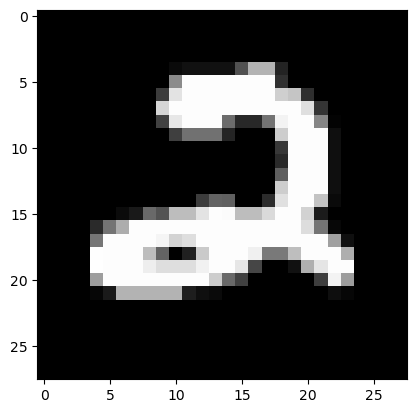

Prediction: [2]


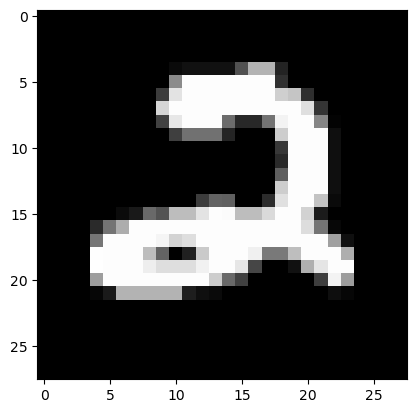

Prediction: [2]


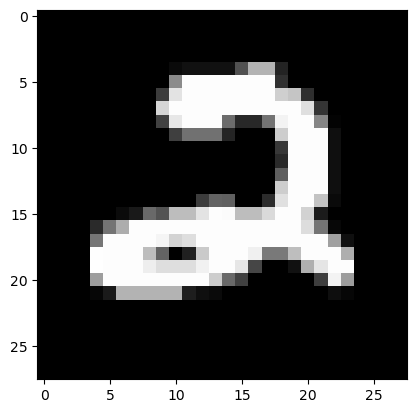

Prediction: [2]


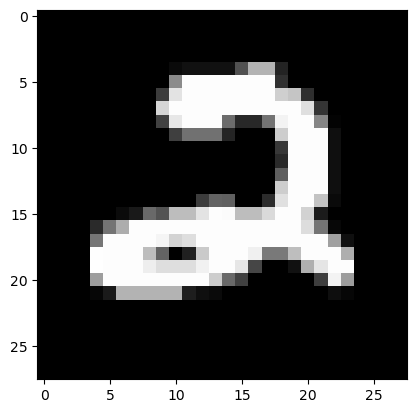

Prediction: [0]


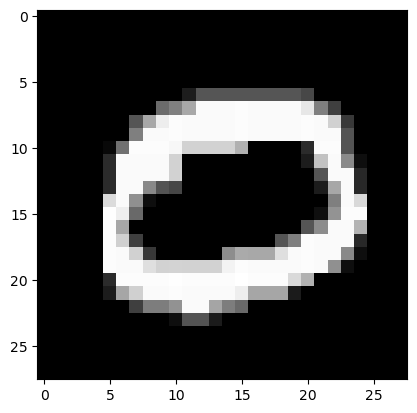

Prediction: [0]


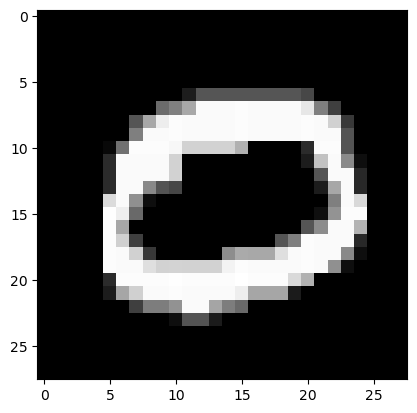

Prediction: [0]


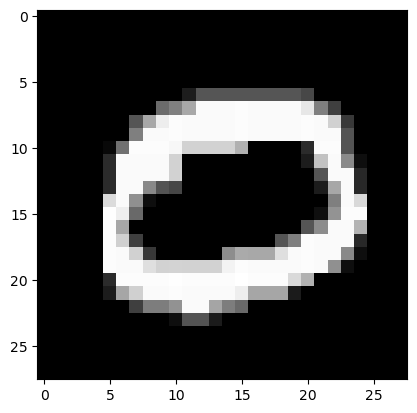

Prediction: [0]


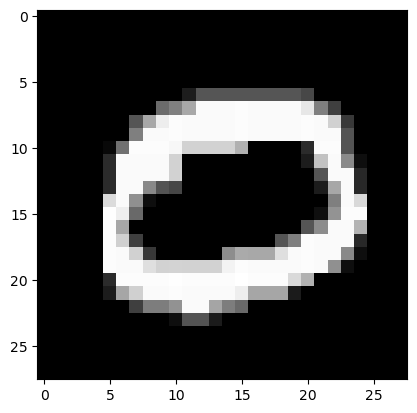

Prediction: [9]


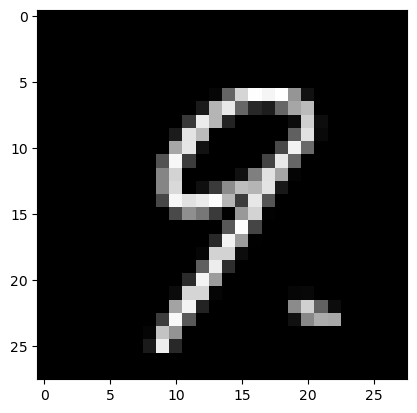

Prediction: [9]


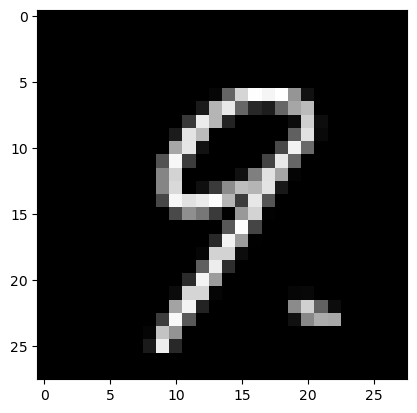

Prediction: [9]


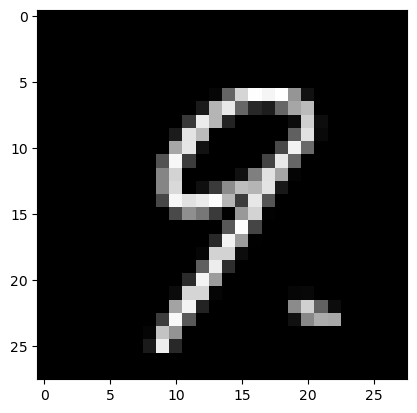

Prediction: [9]


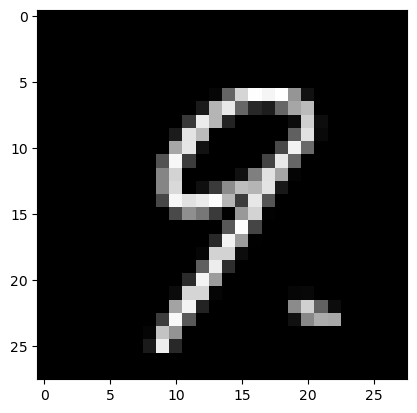

Prediction: [9]


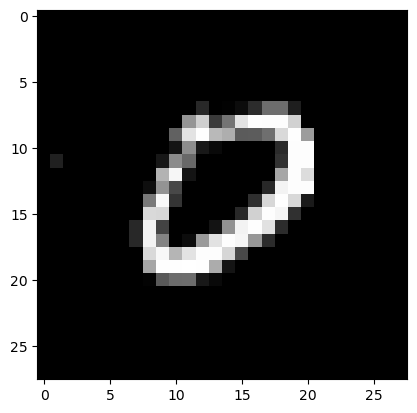

Prediction: [9]


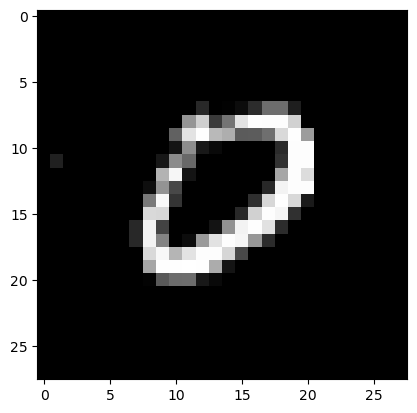

Prediction: [9]


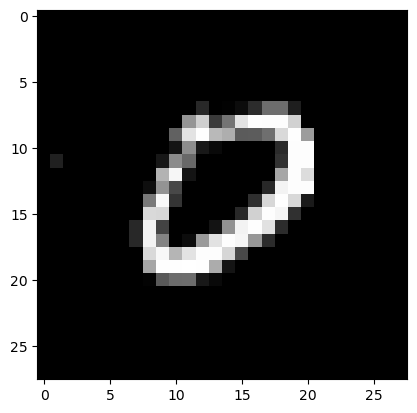

Prediction: [9]


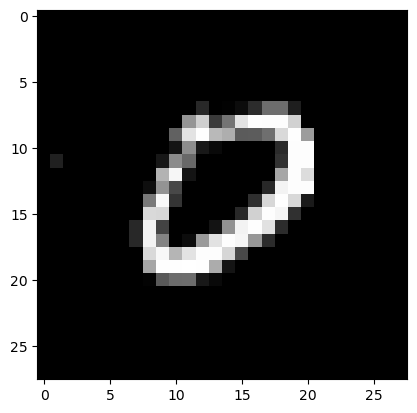

Prediction: [2]


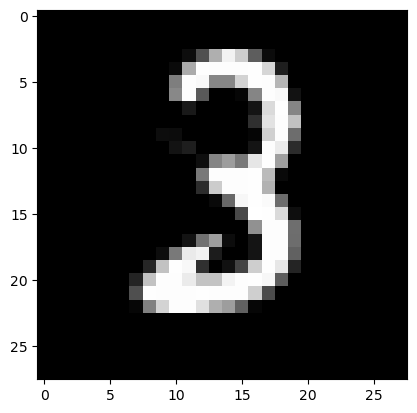

Prediction: [2]


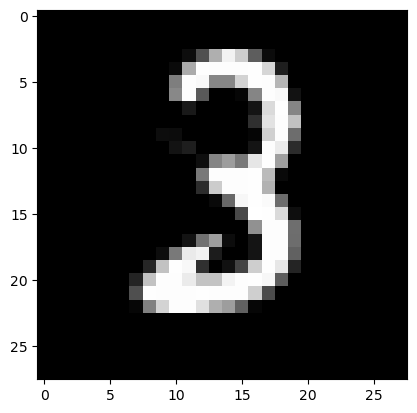

Prediction: [2]


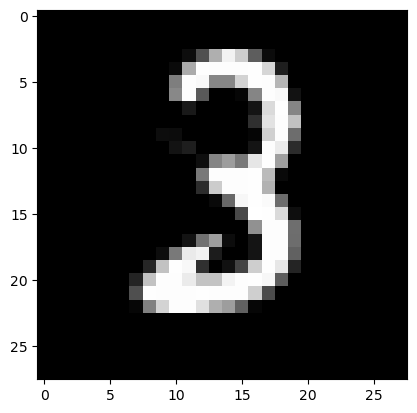

Prediction: [2]


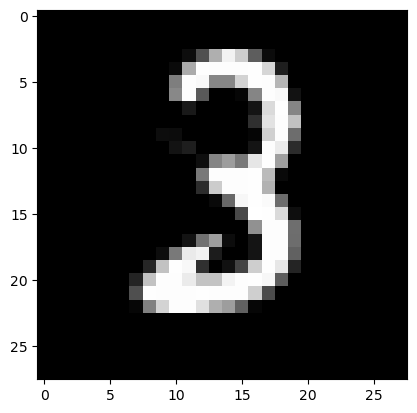

Prediction: [7]


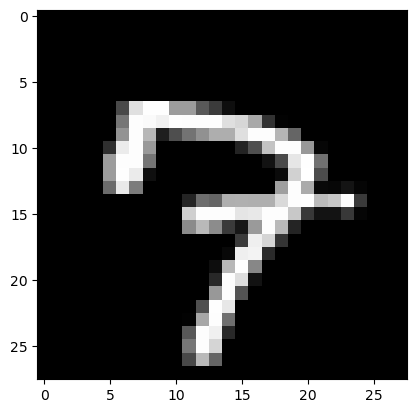

Prediction: [7]


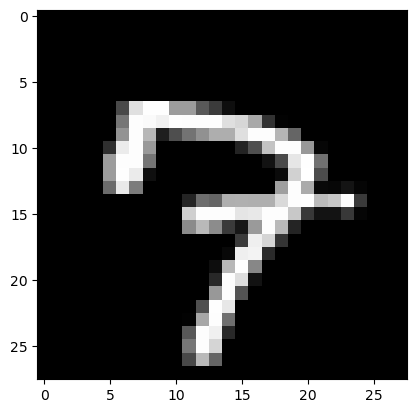

Prediction: [7]


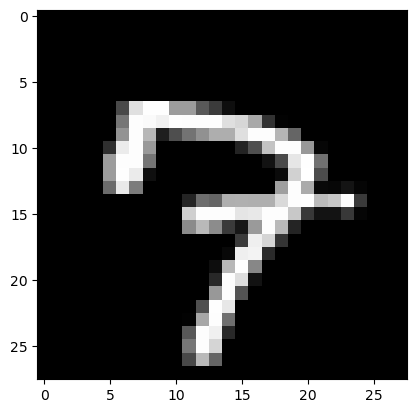

Prediction: [7]


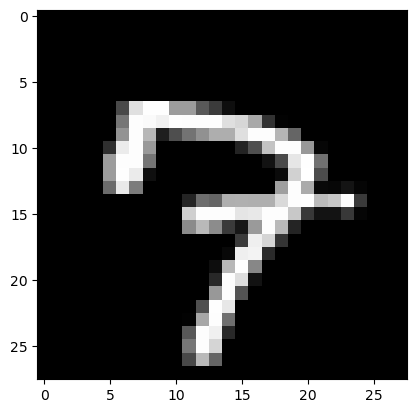

Prediction: [0]


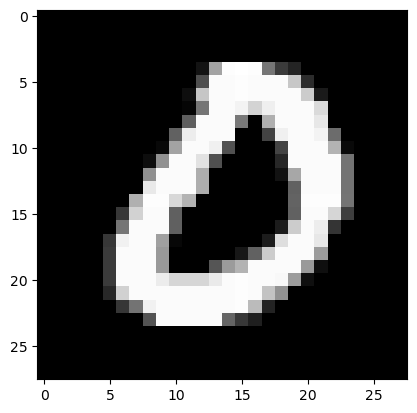

Prediction: [0]


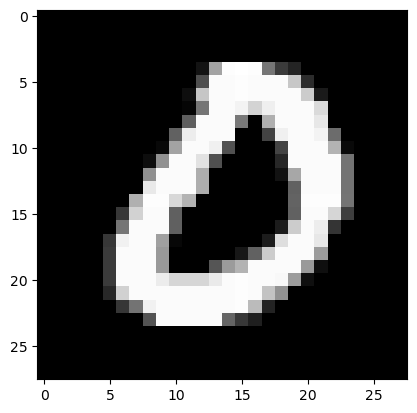

Prediction: [0]


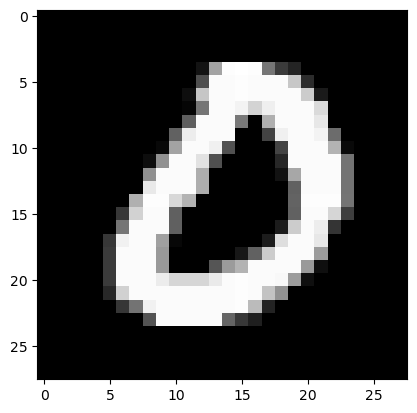

Prediction: [0]


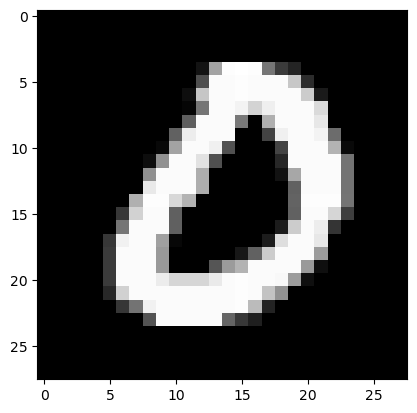

Prediction: [3]


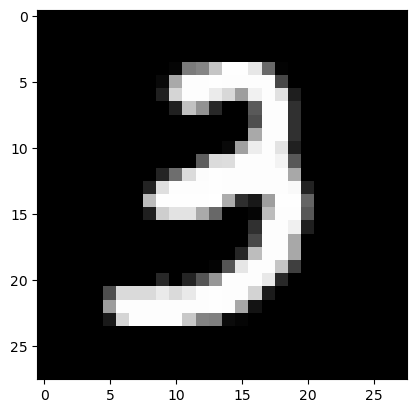

Prediction: [3]


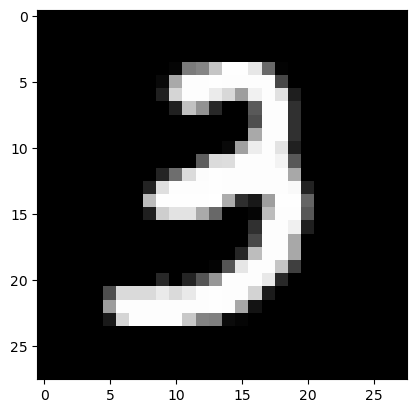

Prediction: [3]


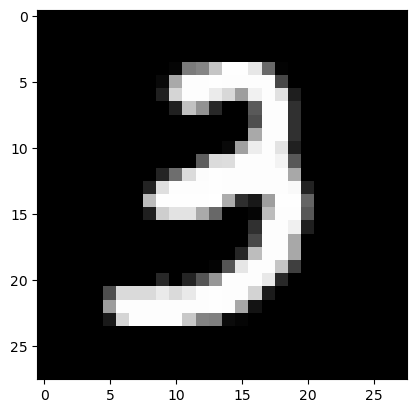

Prediction: [3]


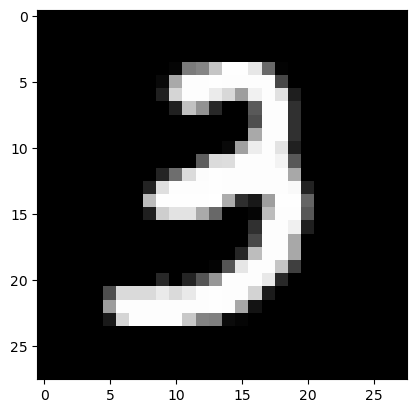

Prediction: [0]


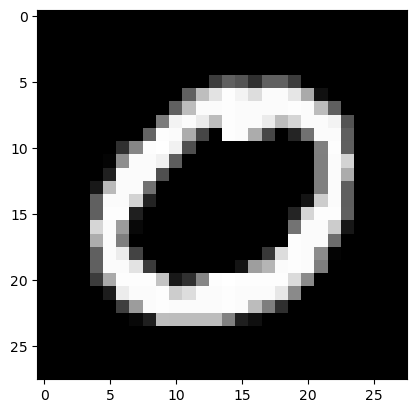

Prediction: [0]


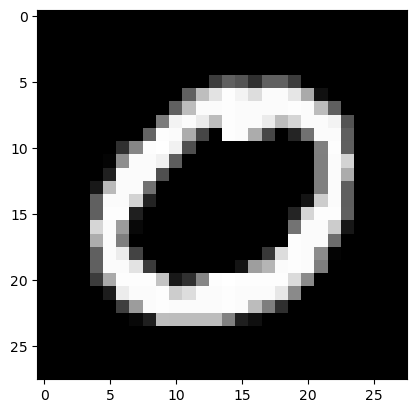

Prediction: [0]


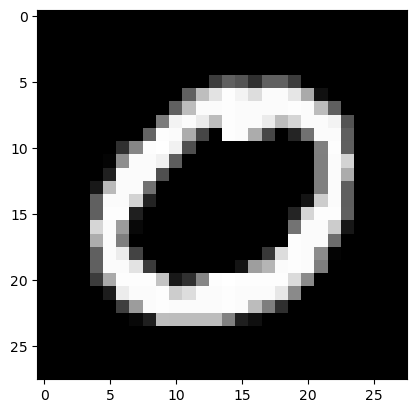

Prediction: [0]


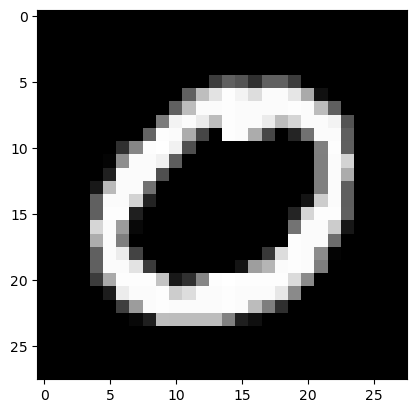

Prediction: [3]


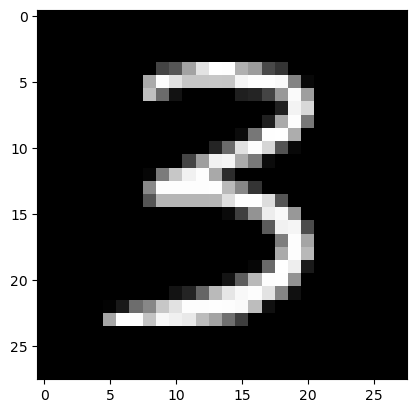

Prediction: [3]


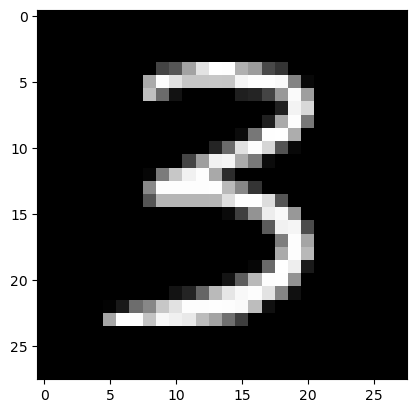

Prediction: [3]


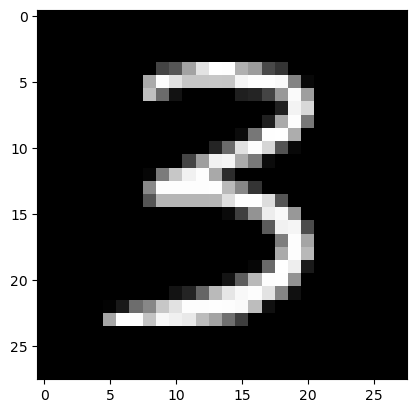

Prediction: [3]


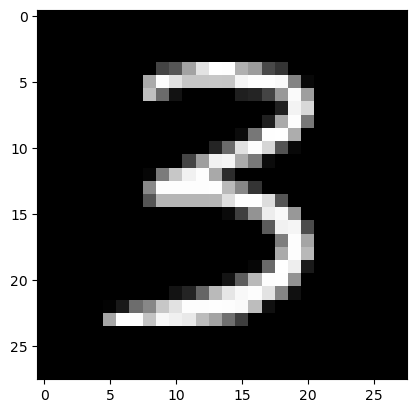

Prediction: [5]


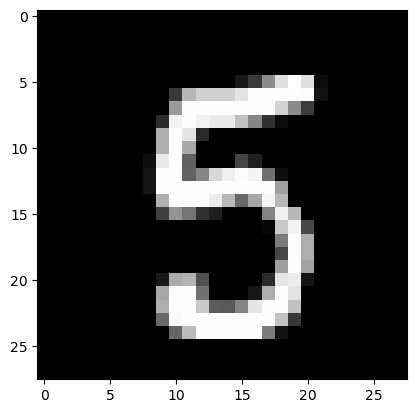

Prediction: [5]


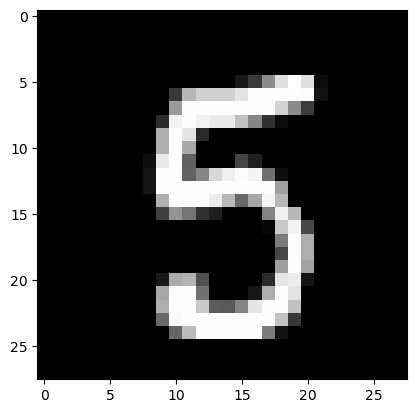

Prediction: [5]


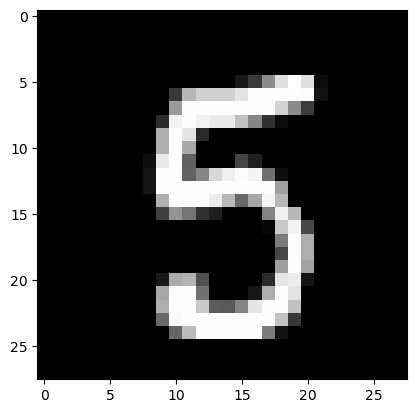

Prediction: [5]


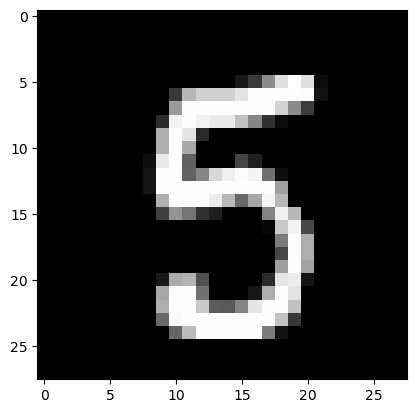

Prediction: [7]


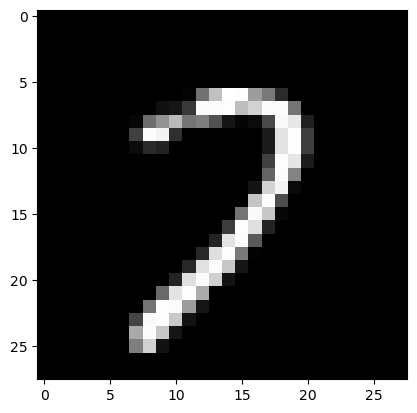

Prediction: [7]


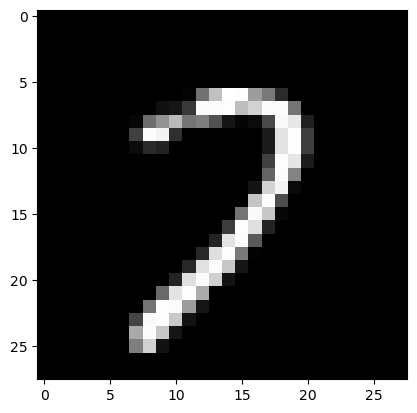

Prediction: [7]


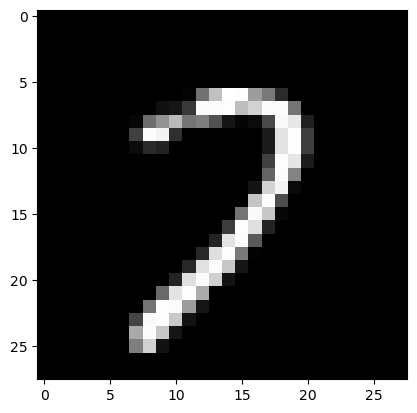

Prediction: [7]


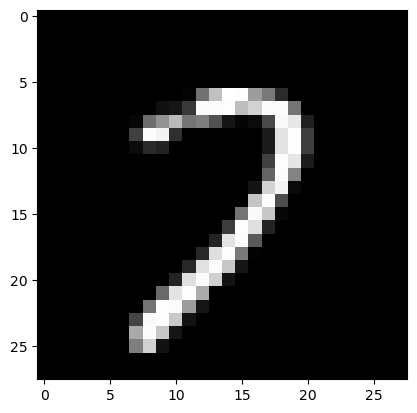

Prediction: [8]


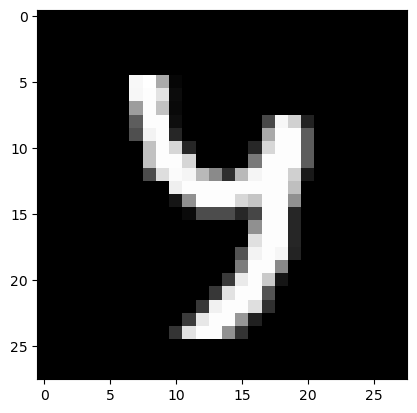

Prediction: [8]


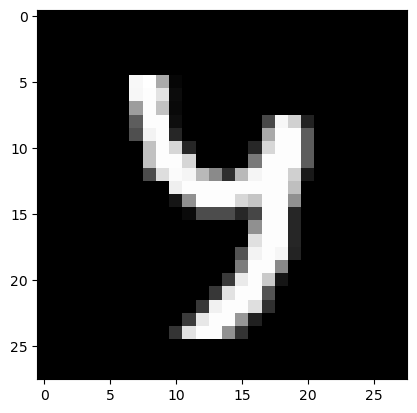

Prediction: [8]


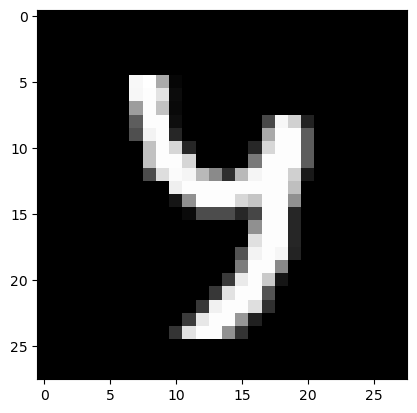

Prediction: [8]


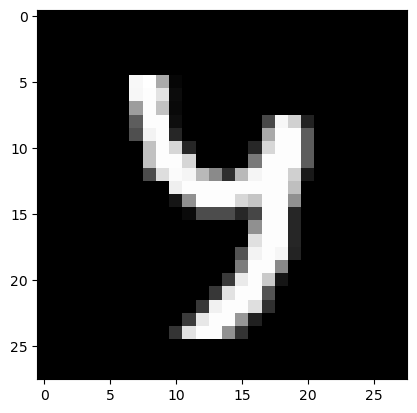

Prediction: [0]


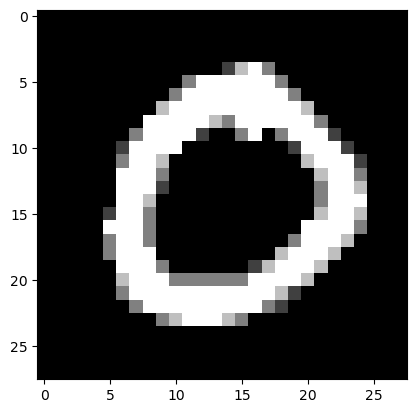

Prediction: [0]


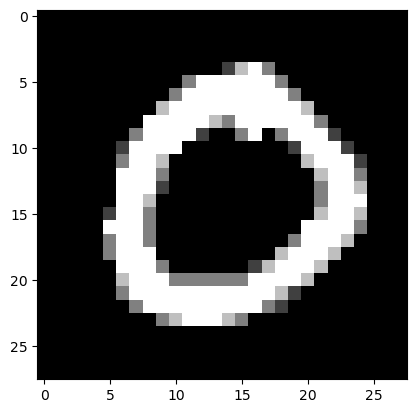

Prediction: [0]


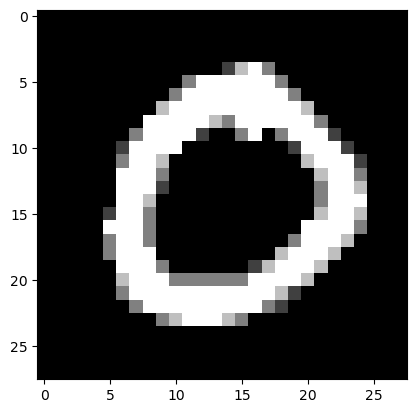

Prediction: [0]


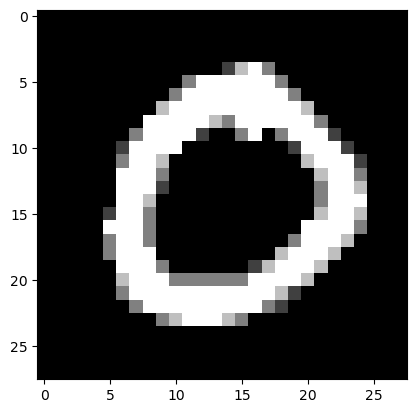

Prediction: [4]


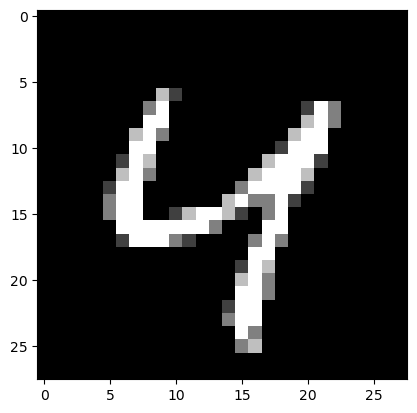

Prediction: [4]


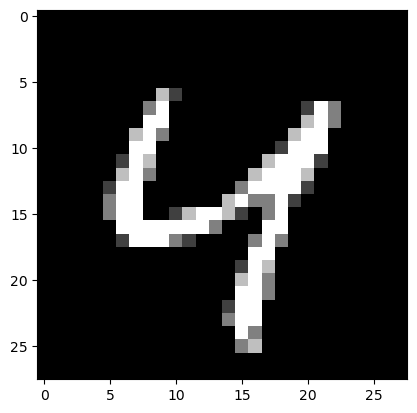

Prediction: [4]


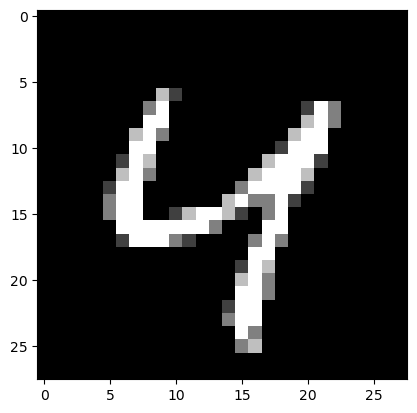

Prediction: [4]


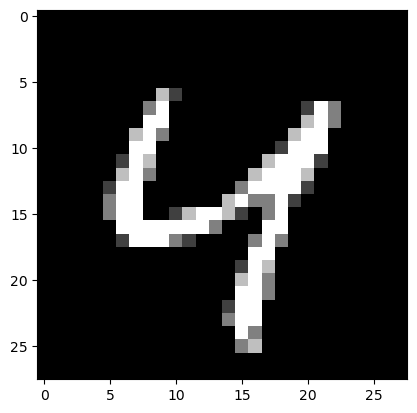

Prediction: [5]


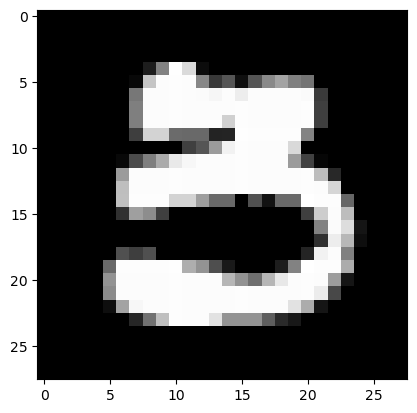

Prediction: [5]


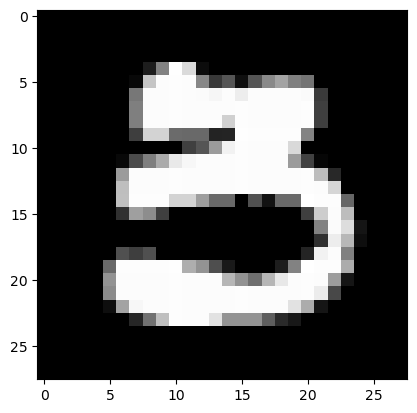

Prediction: [5]


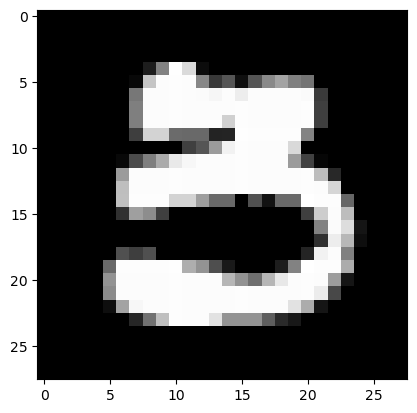

Prediction: [5]


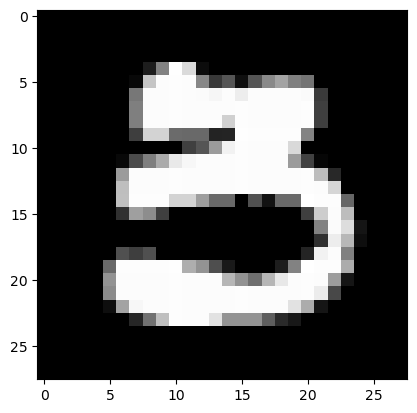

Prediction: [3]


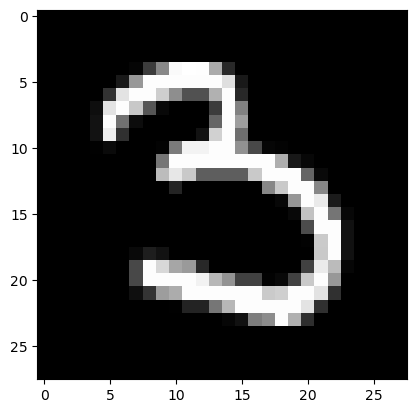

Prediction: [3]


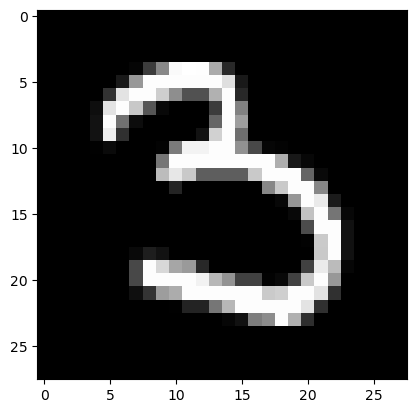

Prediction: [3]


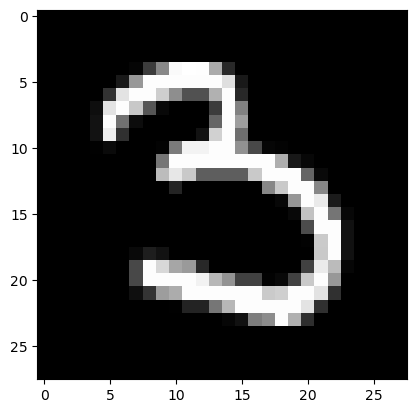

Prediction: [3]


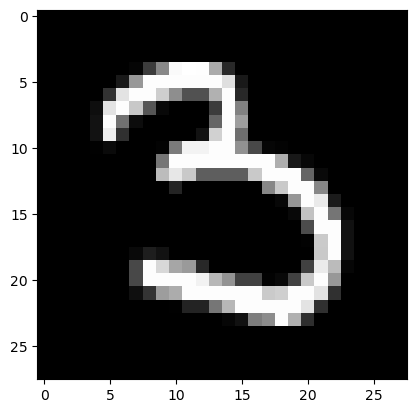

Prediction: [1]


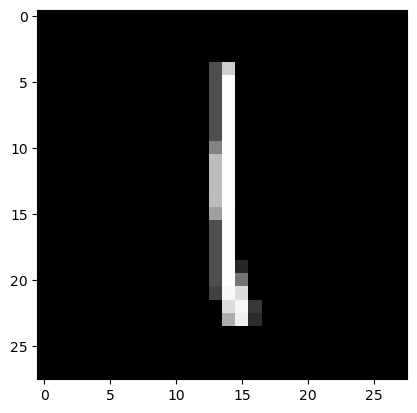

Prediction: [1]


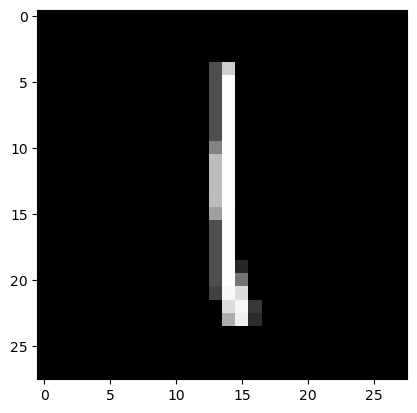

Prediction: [1]


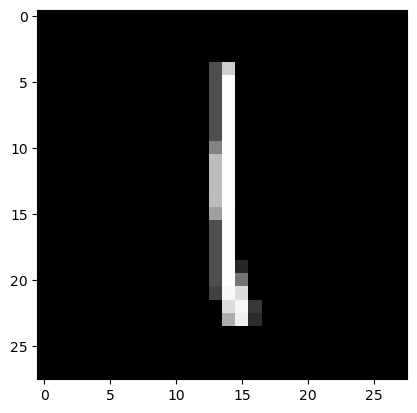

Prediction: [1]


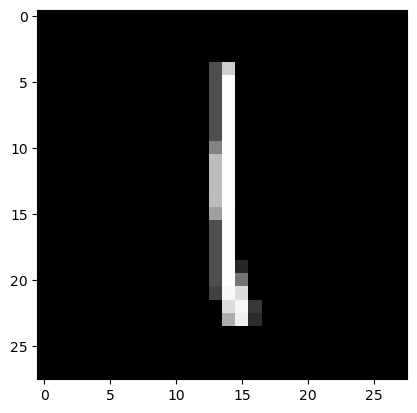

Prediction: [9]


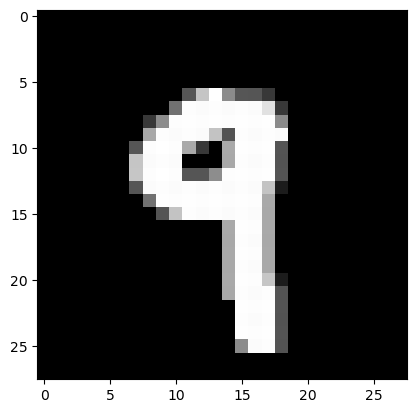

Prediction: [9]


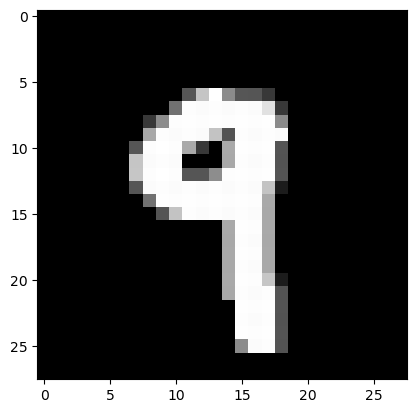

Prediction: [9]


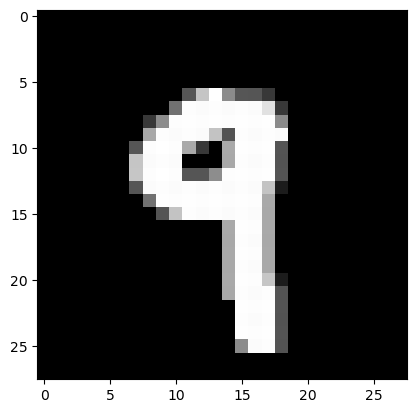

Prediction: [9]


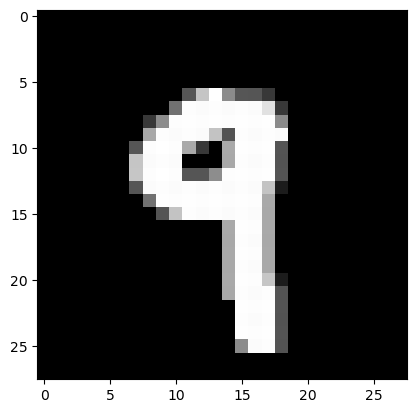

Prediction: [0]


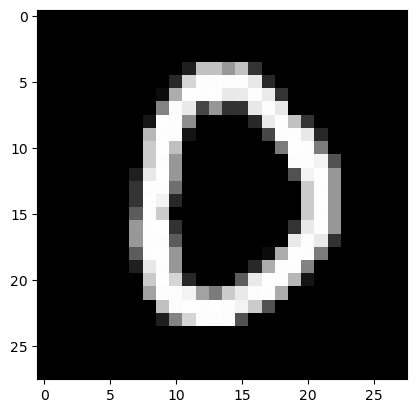

Prediction: [0]


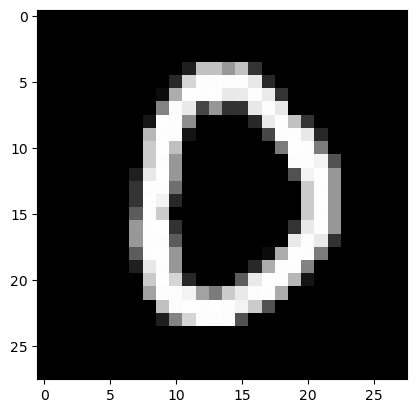

Prediction: [0]


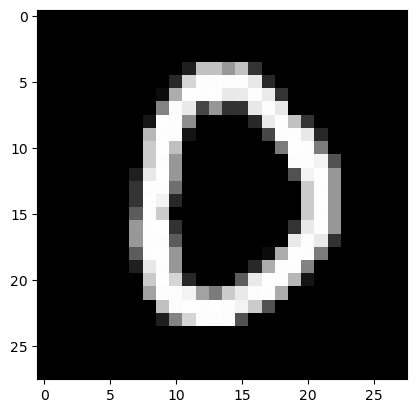

Prediction: [0]


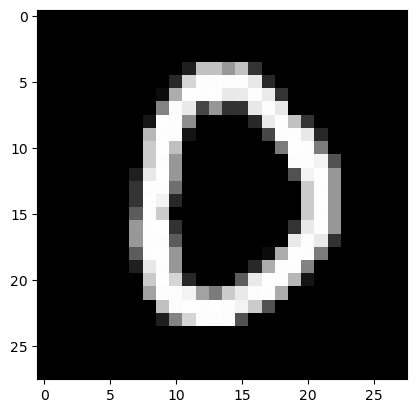

Prediction: [9]


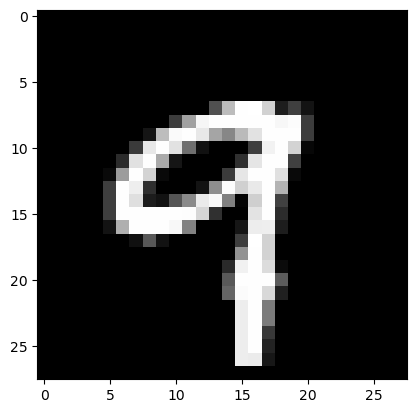

Prediction: [9]


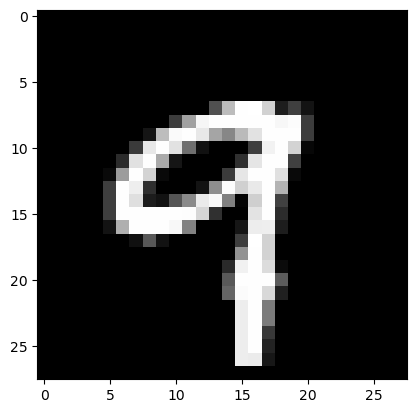

Prediction: [9]


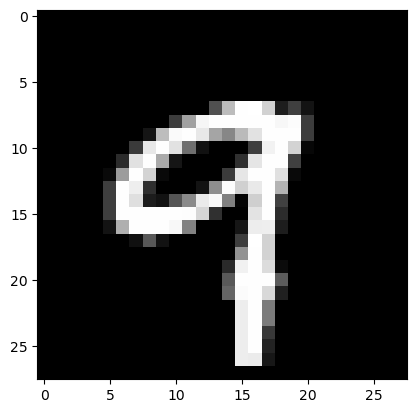

Prediction: [9]


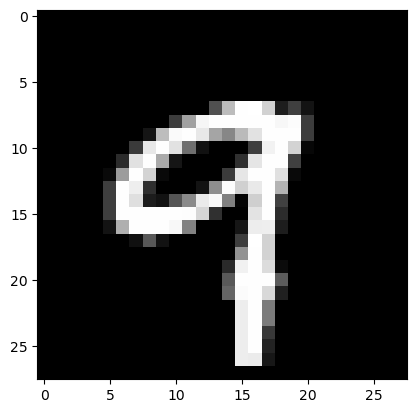

Prediction: [1]


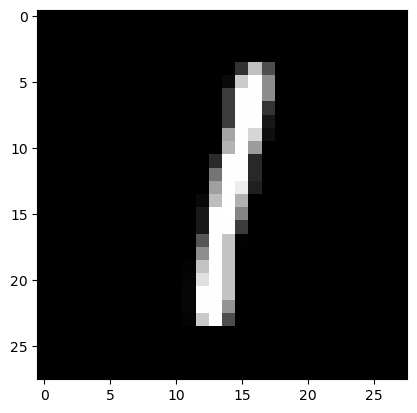

Prediction: [1]


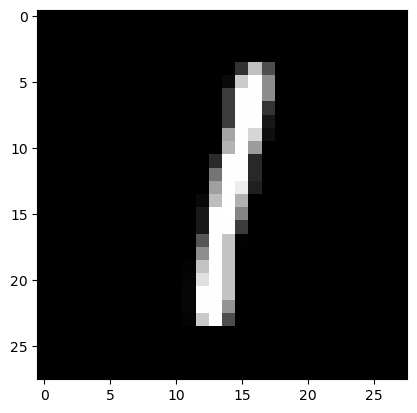

Prediction: [1]


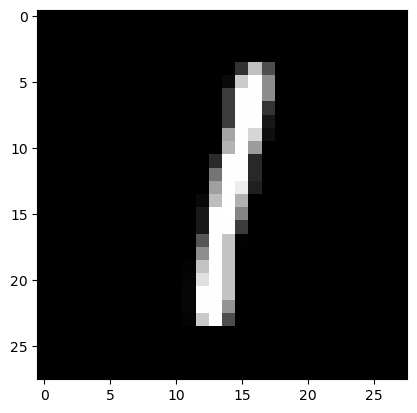

Prediction: [1]


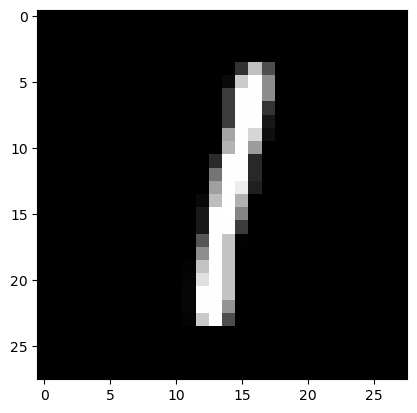

Prediction: [1]


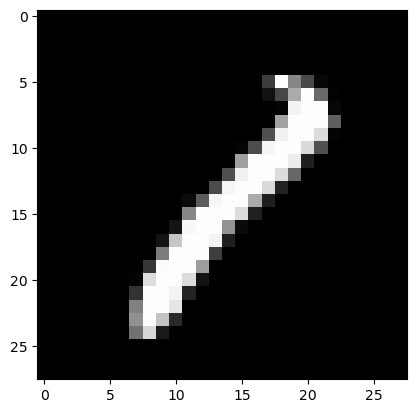

Prediction: [1]


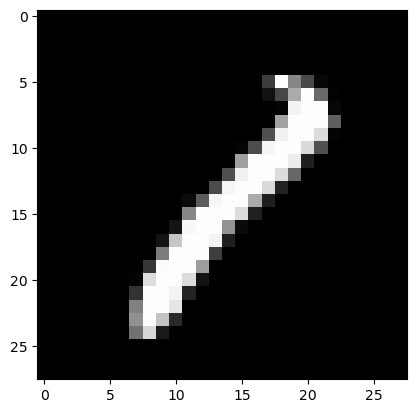

Prediction: [1]


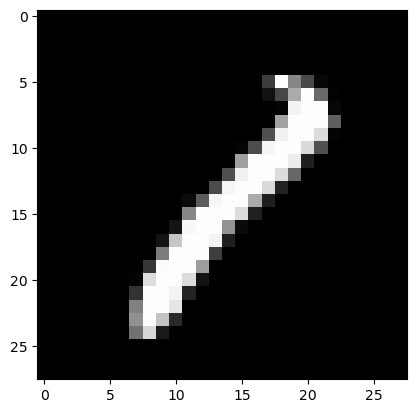

Prediction: [1]


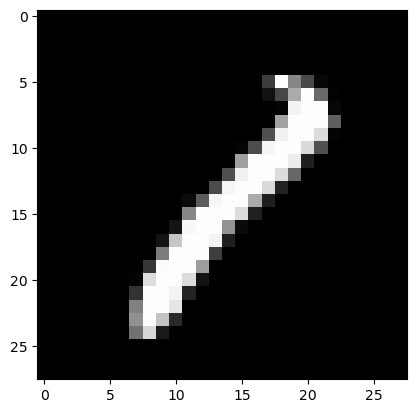

Prediction: [5]


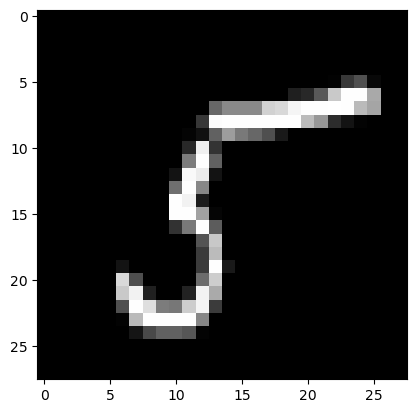

Prediction: [5]


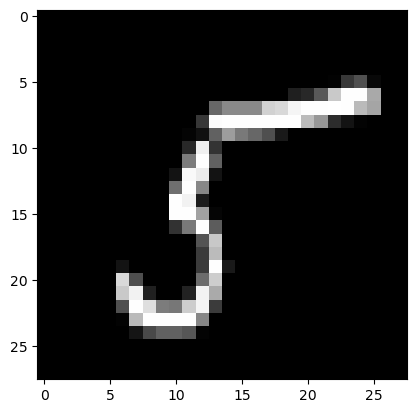

Prediction: [5]


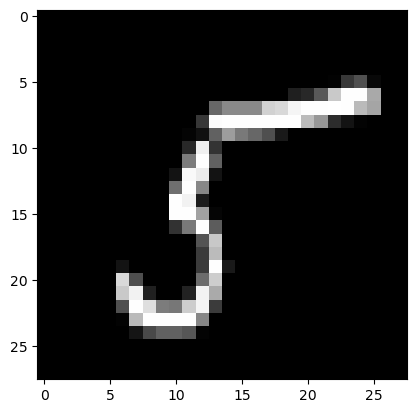

Prediction: [5]


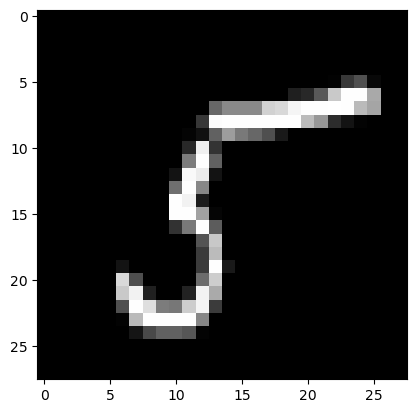

Prediction: [7]


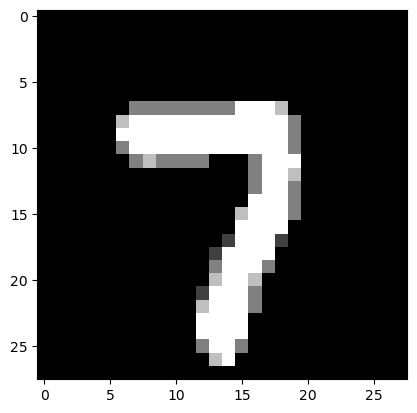

Prediction: [7]


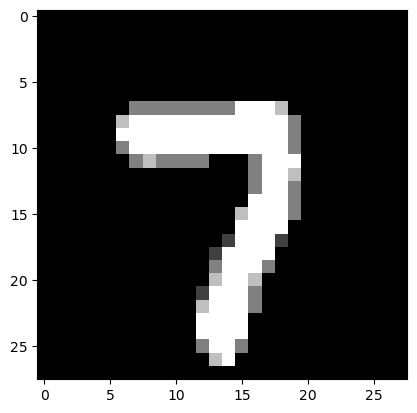

Prediction: [7]


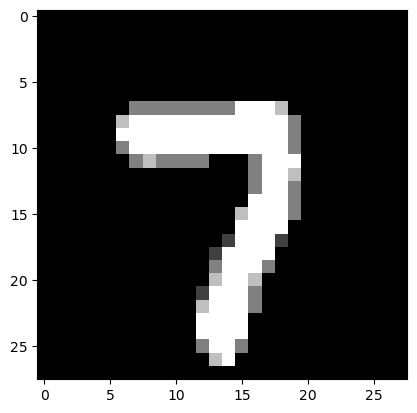

Prediction: [7]


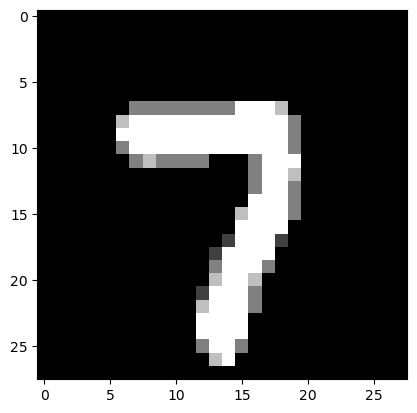

Prediction: [4]


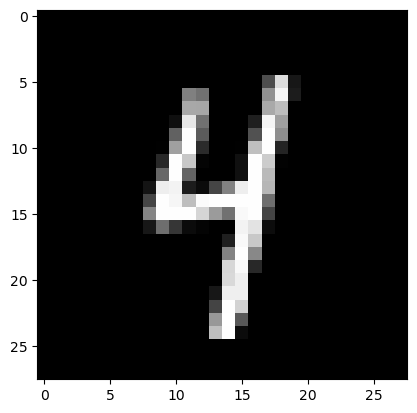

Prediction: [4]


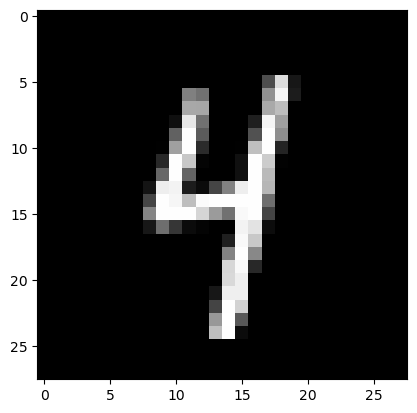

Prediction: [4]


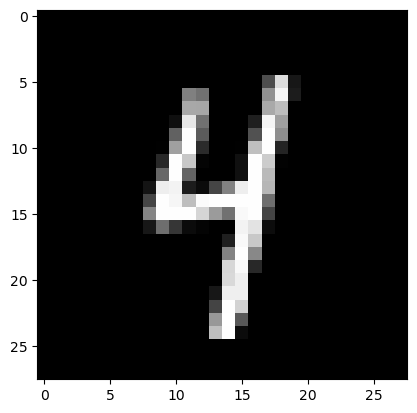

Prediction: [4]


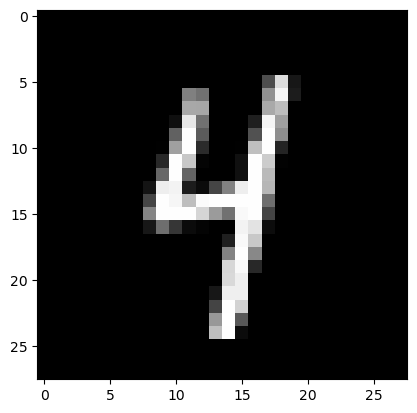

Prediction: [2]


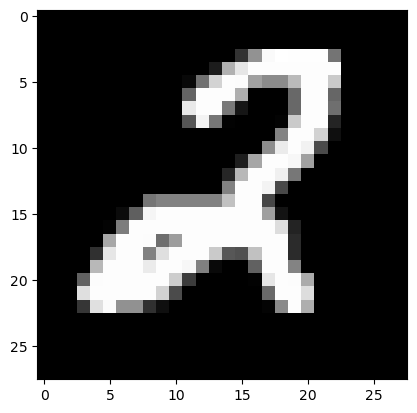

Prediction: [2]


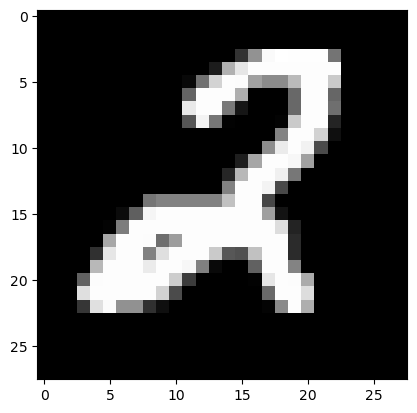

Prediction: [2]


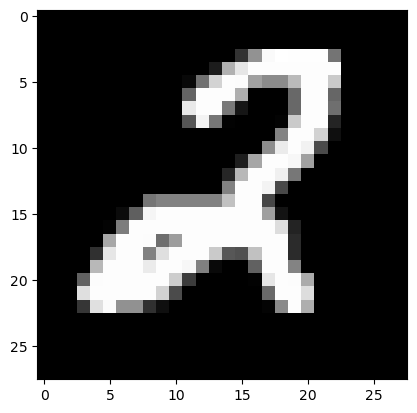

Prediction: [2]


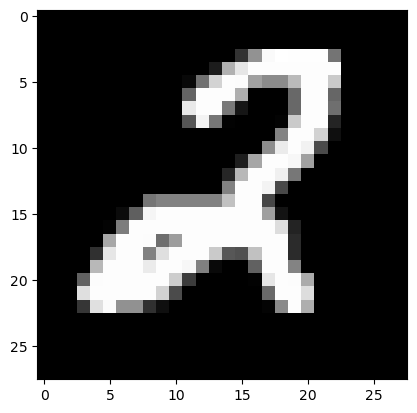

Prediction: [7]


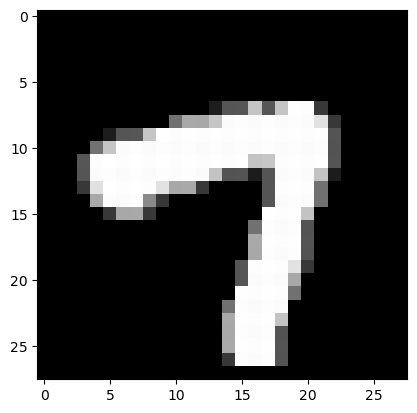

Prediction: [7]


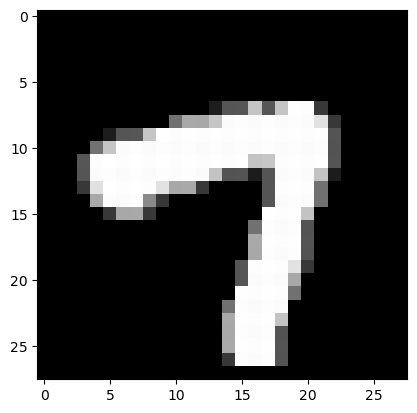

Prediction: [7]


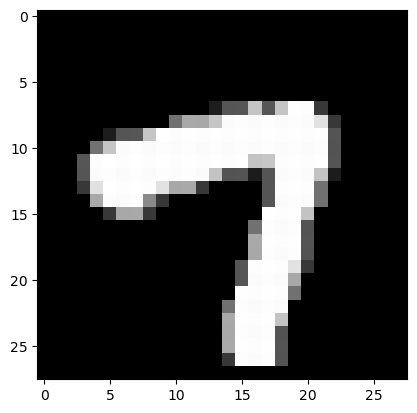

Prediction: [7]


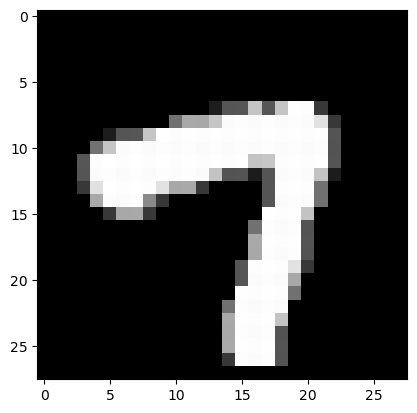

Prediction: [9]


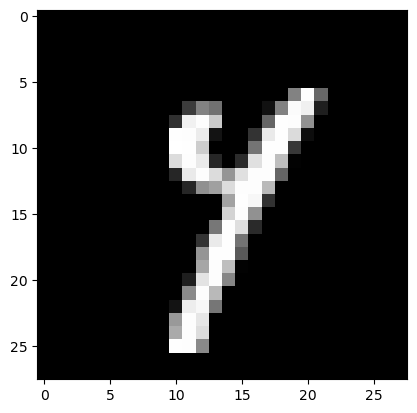

Prediction: [9]


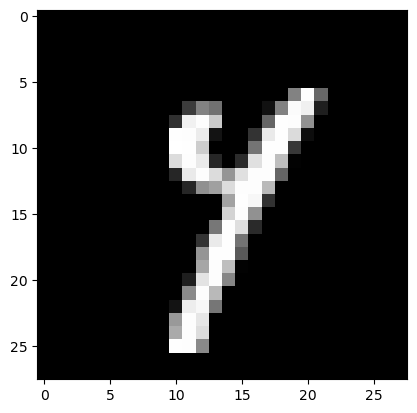

Prediction: [9]


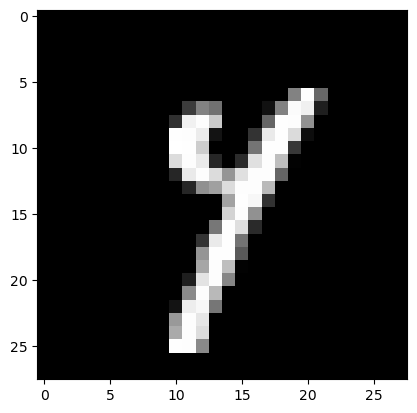

Prediction: [9]


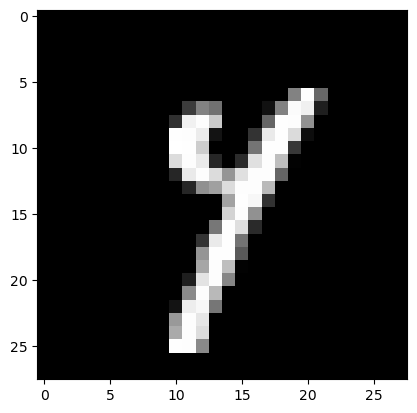

Prediction: [7]


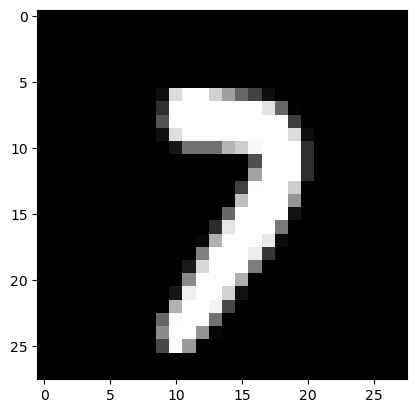

Prediction: [7]


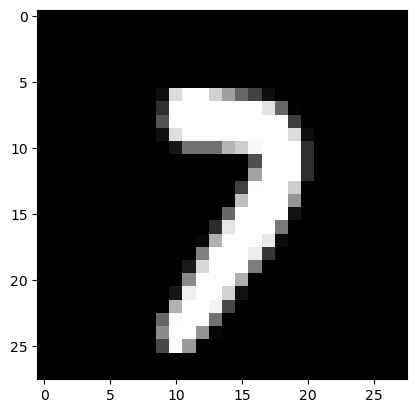

Prediction: [7]


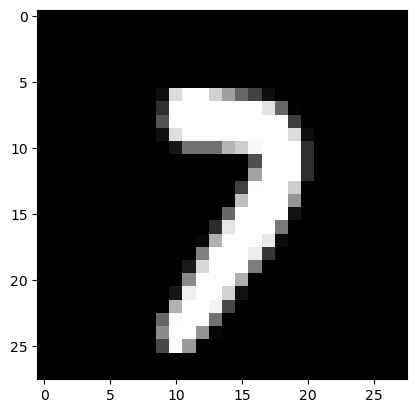

Prediction: [7]


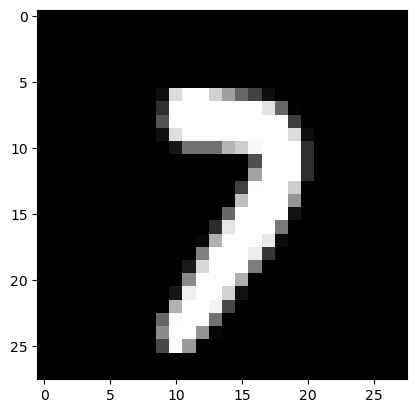

Prediction: [7]


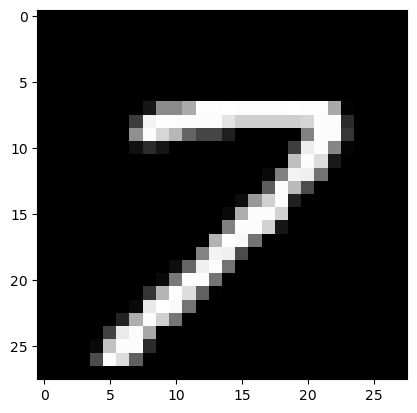

Prediction: [7]


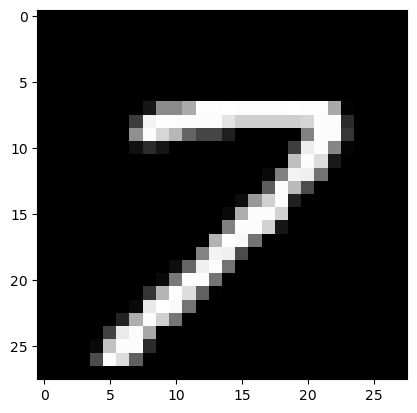

Prediction: [7]


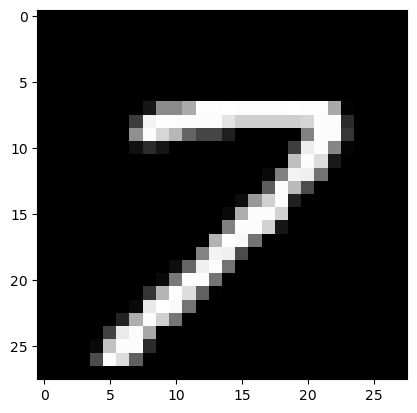

Prediction: [7]


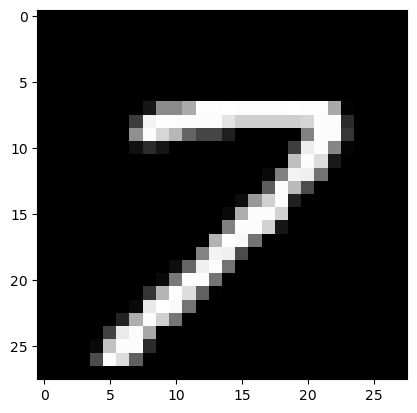

Prediction: [5]


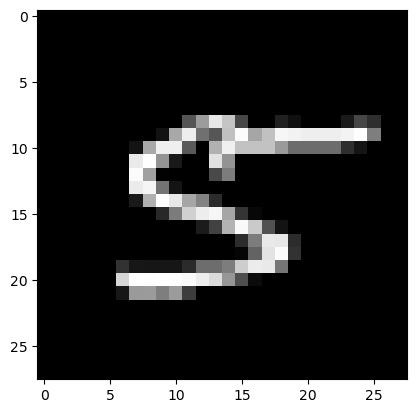

Prediction: [5]


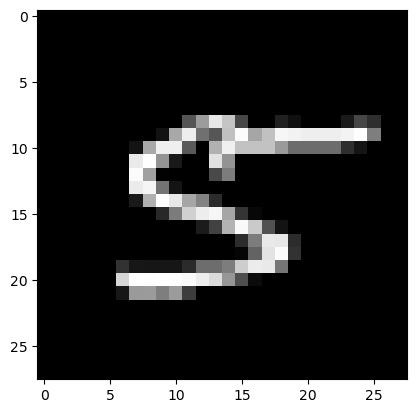

Prediction: [5]


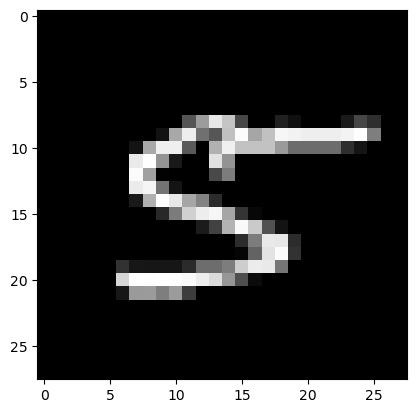

Prediction: [5]


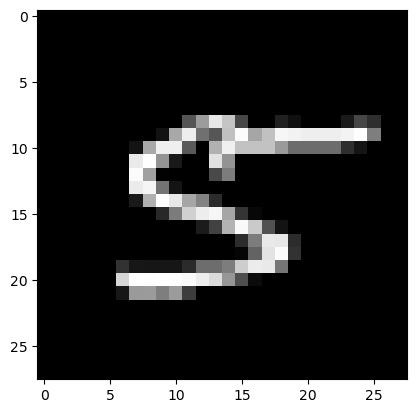

Prediction: [4]


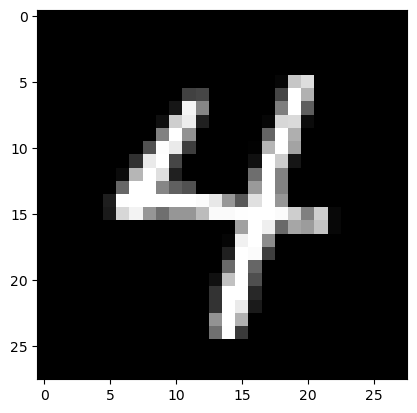

Prediction: [4]


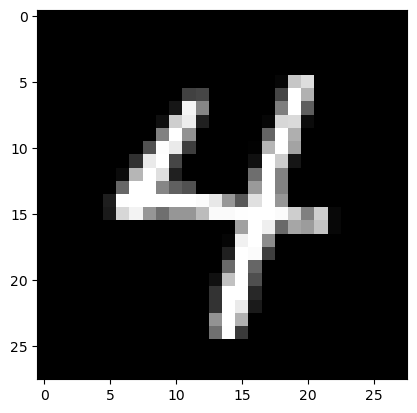

Prediction: [4]


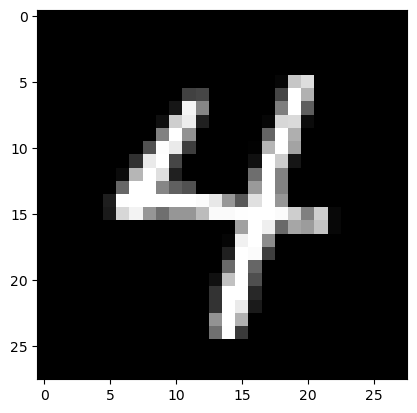

Prediction: [4]


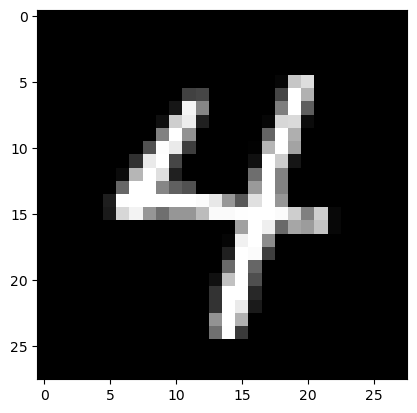

Prediction: [2]


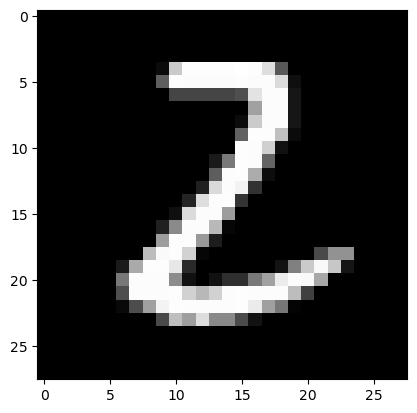

Prediction: [2]


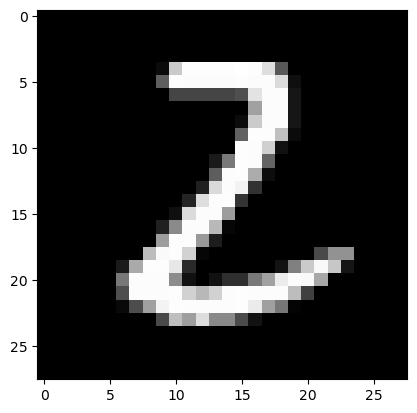

Prediction: [2]


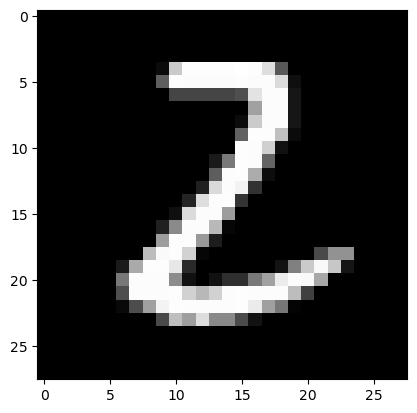

Prediction: [2]


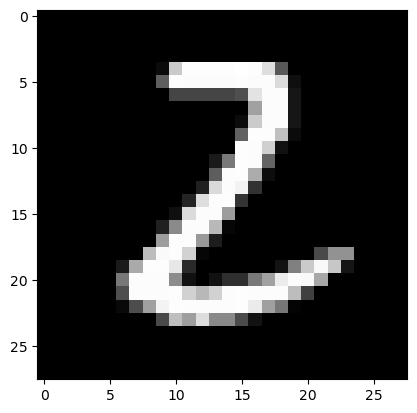

Prediction: [6]


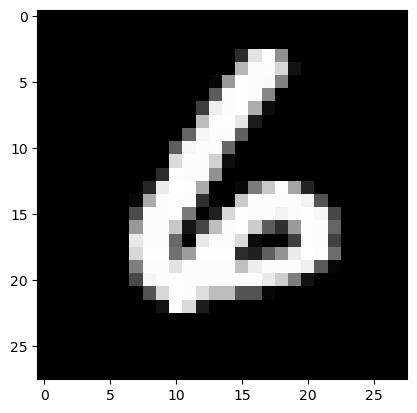

Prediction: [6]


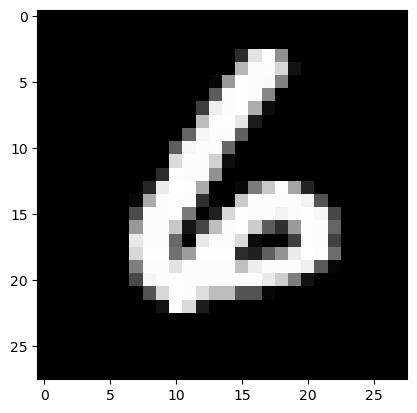

Prediction: [6]


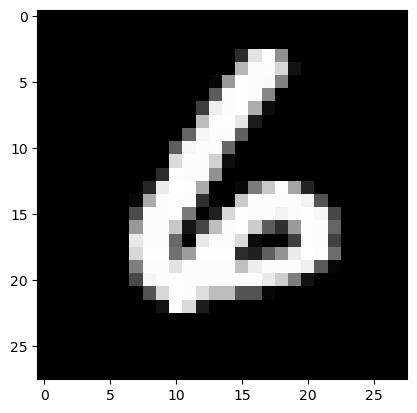

Prediction: [6]


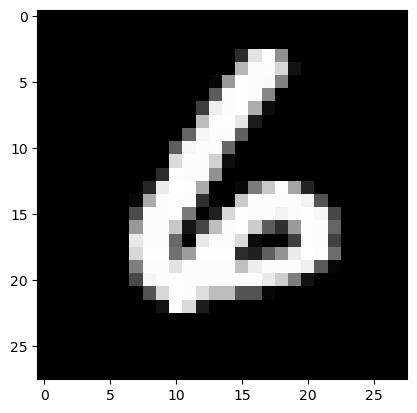

Prediction: [2]


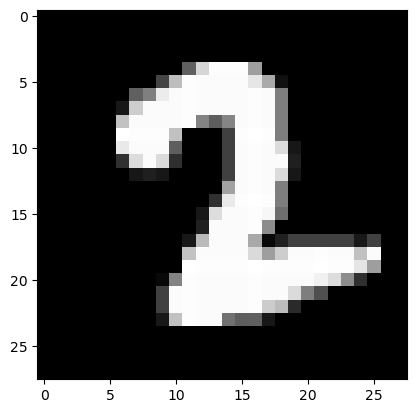

Prediction: [2]


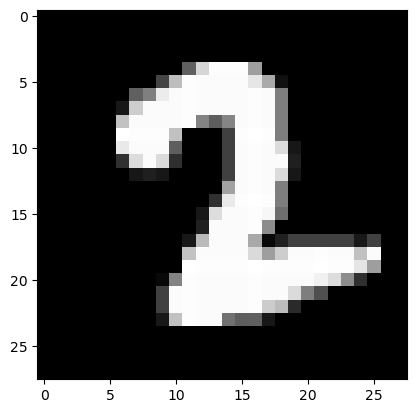

Prediction: [2]


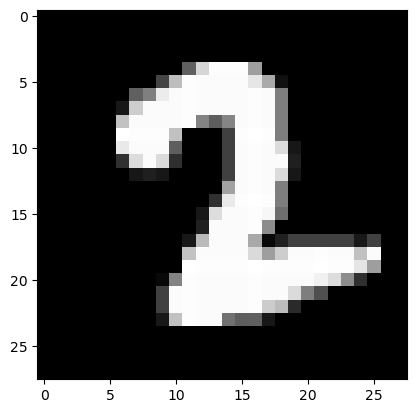

Prediction: [2]


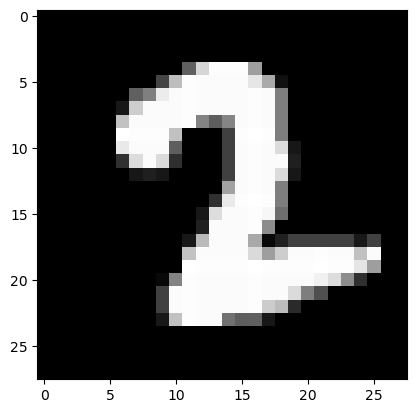

Prediction: [5]


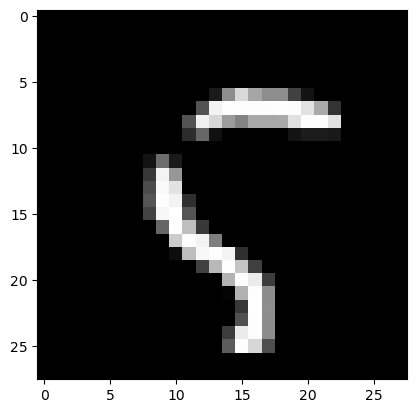

Prediction: [5]


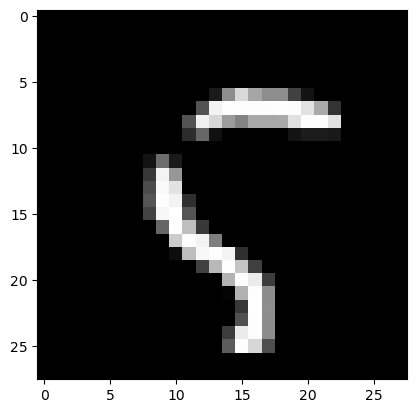

Prediction: [5]


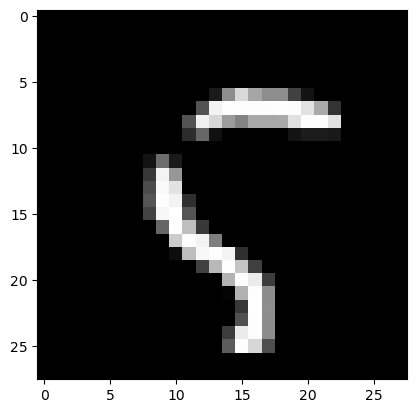

Prediction: [5]


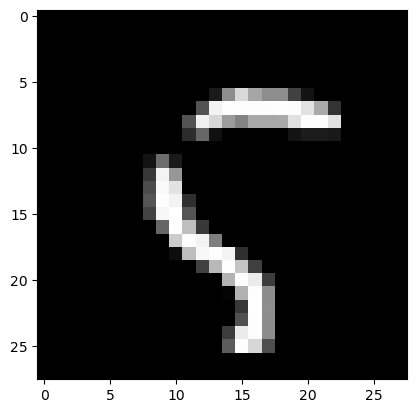

Prediction: [5]


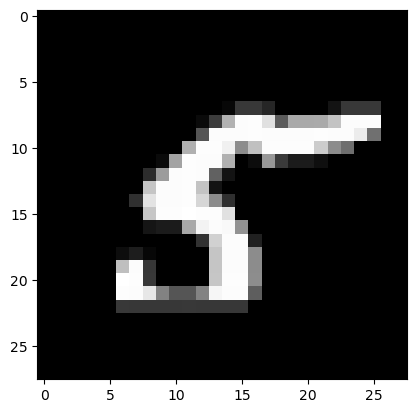

Prediction: [5]


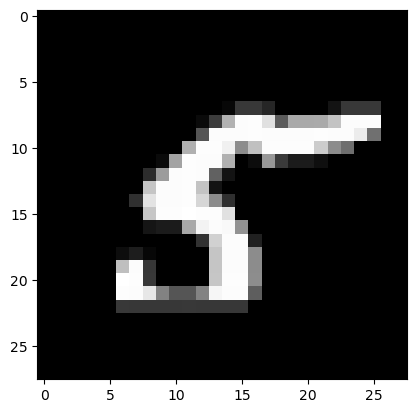

Prediction: [5]


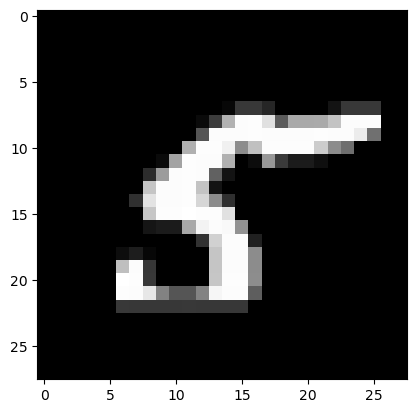

Prediction: [5]


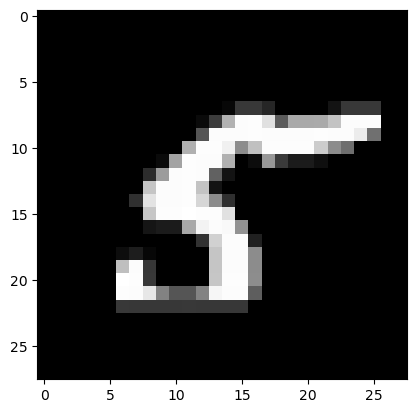

Prediction: [1]


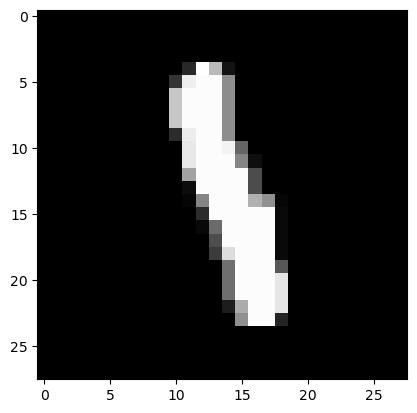

Prediction: [1]


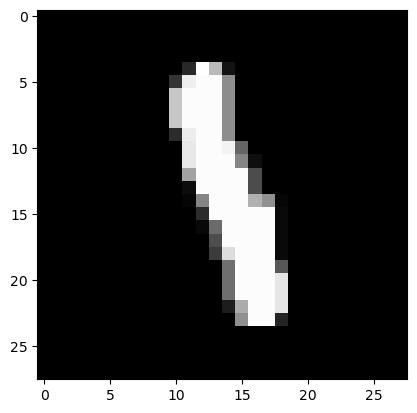

Prediction: [1]


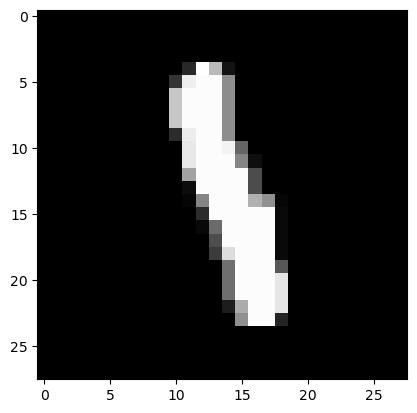

Prediction: [1]


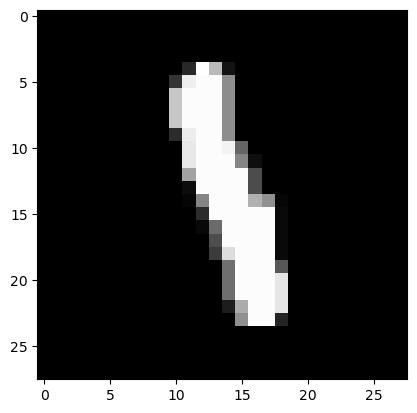

Prediction: [6]


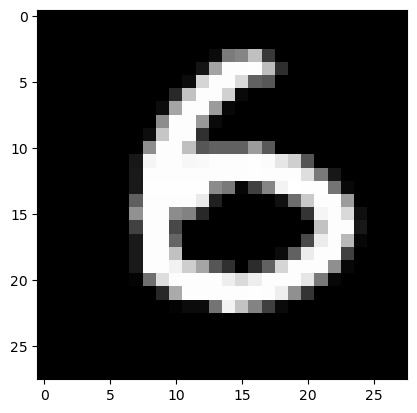

Prediction: [6]


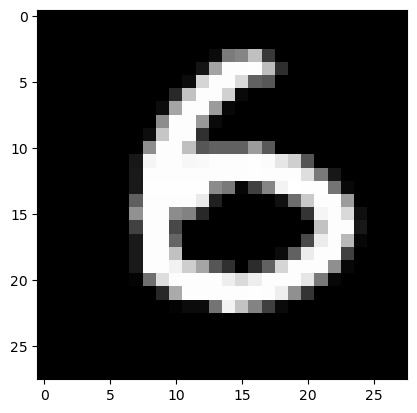

Prediction: [6]


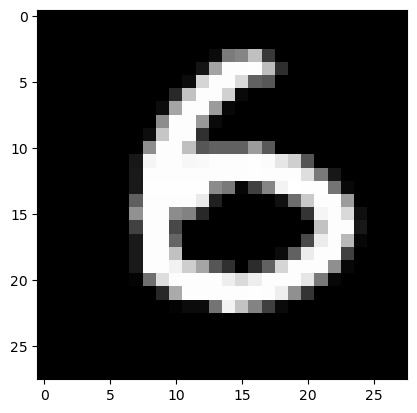

Prediction: [6]


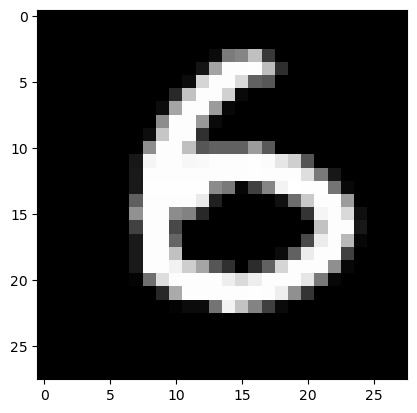

Prediction: [7]


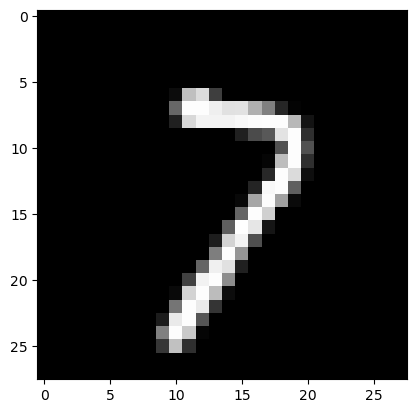

Prediction: [7]


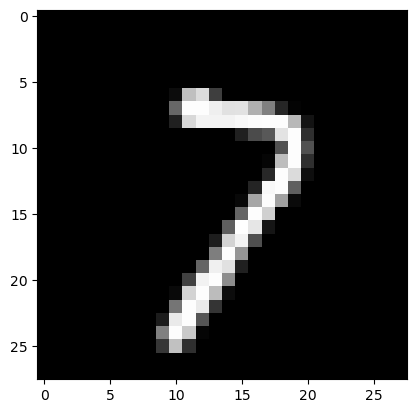

Prediction: [7]


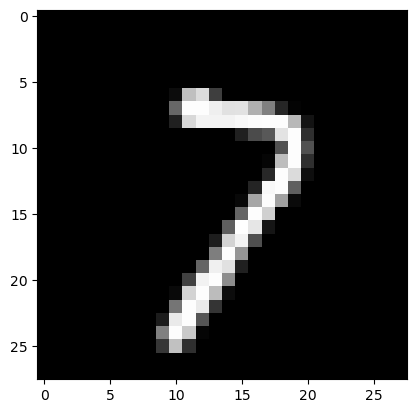

Prediction: [7]


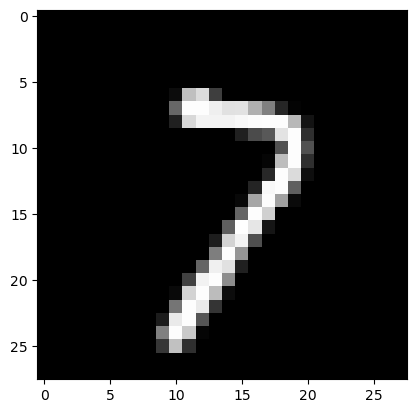

Prediction: [7]


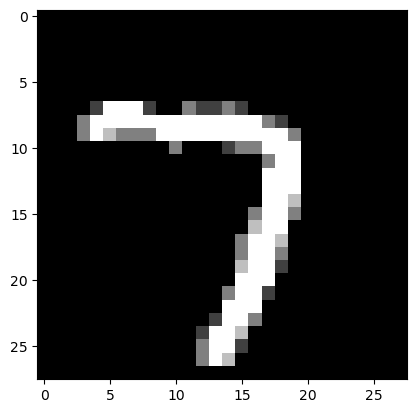

Prediction: [7]


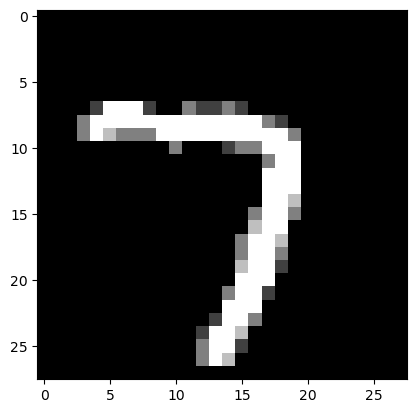

Prediction: [7]


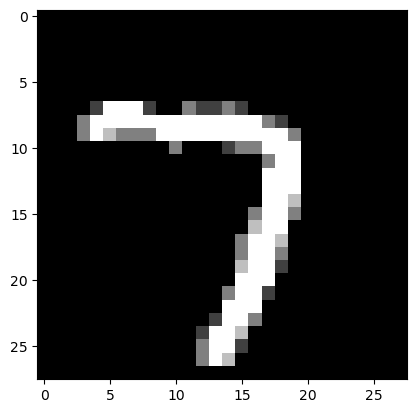

Prediction: [7]


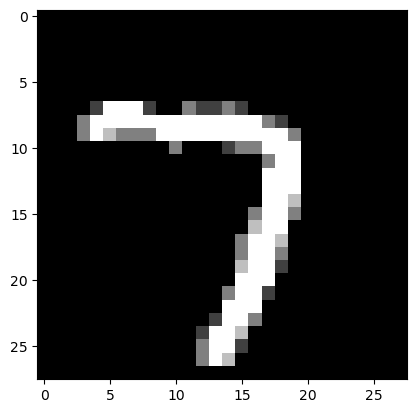

Prediction: [4]


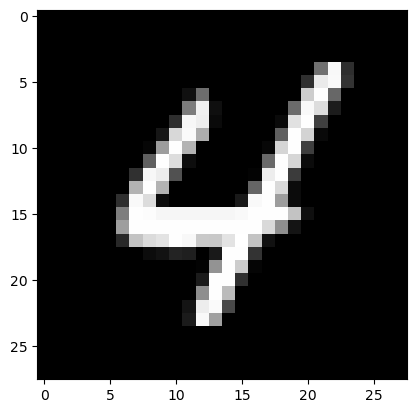

Prediction: [4]


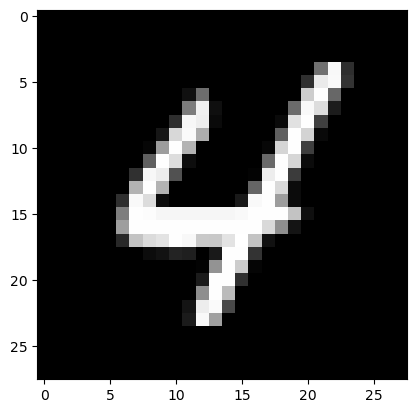

Prediction: [4]


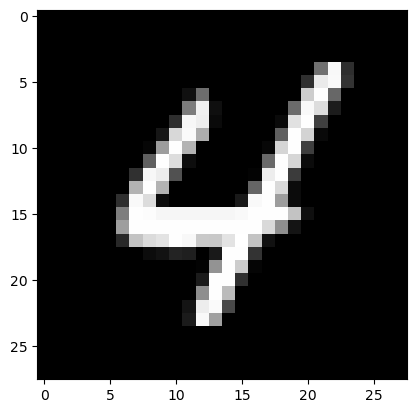

Prediction: [4]


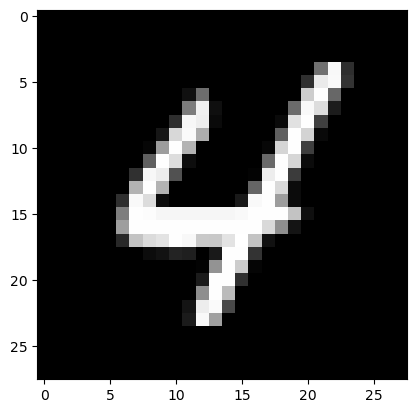

Prediction: [9]


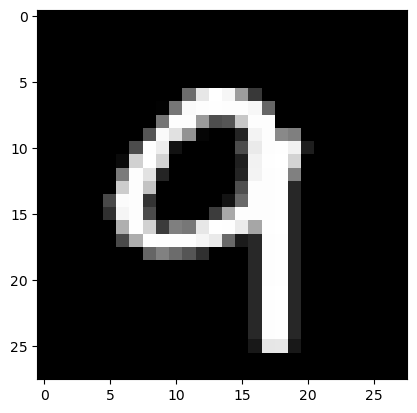

Prediction: [9]


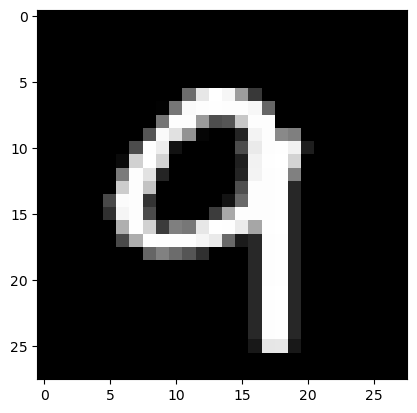

Prediction: [9]


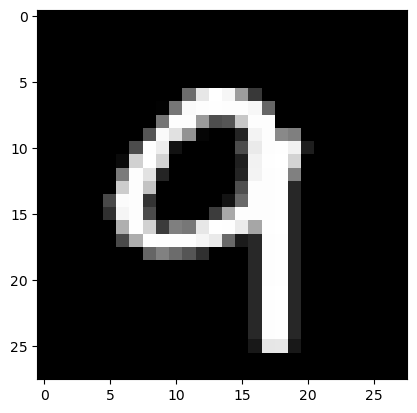

Prediction: [9]


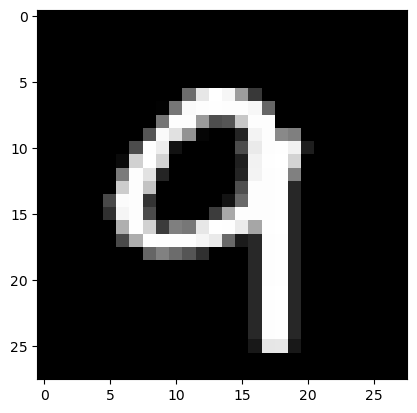

Prediction: [8]


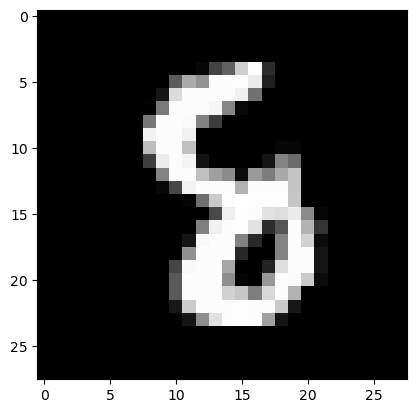

Prediction: [8]


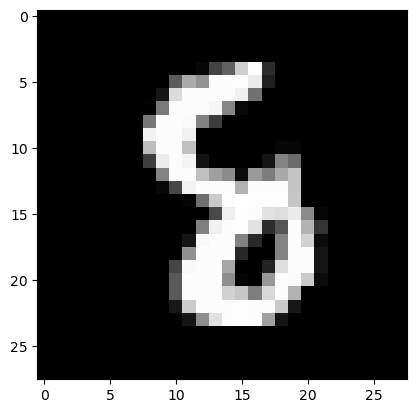

Prediction: [8]


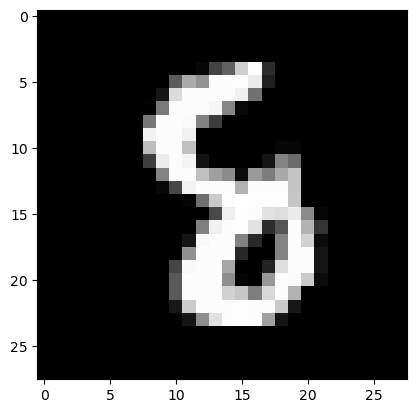

Prediction: [8]


KeyboardInterrupt: 

In [163]:
_, index = X_dev.shape
for i in range(index):
    nn.test_prediction(index=i, X=X_dev, Y=0)
    nn.test_prediction(index=i, X=X_dev, Y=0)
    nn.test_prediction(index=i, X=X_dev, Y=0)
    nn.test_prediction(index=i, X=X_dev, Y=0)